# framework RACC

Ce framework a pour objectif de mettre en place la méthode RACC sur des données MO (SSMIS) et IR (Meteosat)
Les changements à faire dans le code sont marqués par le mot clé TODO

## imports

In [89]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
from matplotlib.font_manager import json_load
import json
import glob
import numpy as np
import datetime
from datetime import datetime, date, timedelta
import sys
from os.path import exists

# importing RACC modules
from segmentation import classification

# importing modules from Images
sys.path.insert(0, r'../Images')
from Image import Image
from File import File
from Geotiff_Format import Geotiff_Format

# importing meteosat API modules
sys.path.insert(0, r'API_meteosat')
from eds_get_nearest import search_nearest,download_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialisation des variables principales

On définit les chemins d'accès principaux afin d'obtenir les variables utiles dans tout le code

In [2]:
# TODO : remplir le chemin d'accès au dossier principal où tous les fichiers seront générés
main_dir = r"../../data/RACC/dec_2020"

# TODO : remplir le chemin d'accès au fichier json contenant les dates et leurs différents attributs
path_dates = r"../../data/RACC/dec_2020/acq_dates.json"

# TODO : remplir le chemin d'accès au fichier json contenant les paramètres de la projection comme la résolution et l'emprise
projection_path = r"param_guy.json"

# TODO : compléter les dates visées dans le format suivant
target_dates = [
    "2020-12-01T20:00:00.000000+0000",
    "2020-12-08T16:00:00.000000+0000",
    "2020-12-12T06:00:00.000000+0000",
    "2020-12-18T01:00:00.000000+0000",
    "2020-12-27T02:00:00.000000+0000"
]


projection = json.load(open(projection_path, "r", encoding="utf-8"))
format = "%Y-%m-%dT%H:%M:%S.%f%z"

In [68]:
def get_dates(path_dates):
    with open(path_dates, "r", encoding="utf-8") as json_dict:
        dates = json.load(json_dict)
    return dates
    
def save_dates(dates,path_dates):
    with open(path_dates, 'w', encoding="utf-8") as json_dict:
        json.dump(dates, json_dict, indent=4, default=str)
        
# dictionnaire dont la clé est le jour avec la date entière visée comme premier élément
dates = {d.split(" ")[0]:{"target":d} for d in target_dates}
save_dates(dates,path_dates)

## Extraction des images SSMIS 

In [70]:
def search_SSMI(src_dir,tg_date,frequences,projection):
    """
    Renvoie les fichiers SSMIS correspondant aux fréquences données 
    et dont l'acquisition englobe la date d'intérêt et comprenant un maximum d'information

    Args : 
        src_dir (string) : chemin vers le dossier contenant l'ensemble des images téléchargées sur la période
        tg_date (datetime) : date visée
        freq (list) : liste des fréquences recherchées, le 3e caractère indique la polarisation (* si celle-ci n'importe pas)
        projection (dict) : dictionnaire contenant les paramètres de projection, notamment l'emprise

    Return
        output_dict (dict) : dictionnaire avec les fréquences retenues comme clé, associées au chemin vers le fichier associé
    """
    # construction du dictionnaire files_per_date donnant tous les fichiers disponibles pour un capteur donné sur la période
    year = tg_date.year # récupération de l'année et du nombre de jours depuis le 1er janvier
    days = (tg_date.date() - date(year,1,1)).days
    files_per_date = {}
    for offset in [-2,-1,0,1,2]: # période de recherche élargie pour s'assurer d'obtenir toutes les images possibles sur cette zone
        fns = glob.glob(src_dir+ rf"/*/*{year}{days+offset}-*.nc")
        for fn in fns: # chaque fichier acquis dans la période est parcouru
            file_base = File(fn)
            acq_start, acq_end = file_base.getAcqDates() # récupération de la date d'acquisition
            if acq_start < tg_date < acq_end: # vérification que la date visée correspond bien à la période
                part_fn = fn.split("NSIDC-")[1].split("-")
                capteur,yyyydd,freq,period = part_fn[2],part_fn[3],part_fn[4],part_fn[5]
                id = capteur+yyyydd+period
                try:
                    files_per_date[id][freq] = fn
                except KeyError:
                    files_per_date[id] = {freq:fn}

    # Recherche du capteur donnant l'image la moins corrompue
    zero_aver_min, id_min, valid_frequences_min = np.iinfo(np.int32).max, None, None
    for id in files_per_date.keys():
        frequences_star = [f_str[:2] for f_str in frequences if "*" in f_str] # liste spécifique pour les fréquences sans polarisation spécifiée 
        zero_aver = 0 ; files_per_freq = files_per_date[id] ; valid_frequences = []
        for f in files_per_freq.keys(): # on parcourt chaque fréquence pour ouvrir le fichier associé
            if f in frequences: # fréquence du fichier bien dans la liste des fréquences
                file = File(files_per_freq[f])
            elif f[:2] in frequences_star: # de même si la polarisation de la fréquence n'est pas spécifiée
                frequences_star.remove(f[:2]) 
                file = File(files_per_freq[f])
            else : 
                continue
            try : # on compte les occurences de 0 pour déterminer si le fichier est corrompu
                img = file.project(r"../../data/test.tiff",projection,"TB") # TODO : changer ça
                unique, counts = np.unique(img.array, return_counts=True)
                zero_rate = dict(zip(unique, counts))[0]/(img.array.shape[0]*img.array.shape[1])
            except KeyError: # aucune occurence de 0
                zero_rate = 0
            zero_aver += zero_rate ; valid_frequences.append(f)
        
        if len(valid_frequences) == len(frequences) - len(frequences_star): # on a bien toutes les fréquences demandées
            zero_aver = zero_aver / len(valid_frequences) 
            if zero_aver < zero_aver_min : # recherche du fichier le moins corrompu
                zero_aver_min, id_min, valid_frequences_min = zero_aver, id, valid_frequences

    output_dict = {val_f:files_per_date[id_min][val_f] for val_f in valid_frequences_min}        
    return output_dict

def select_and_project_SSMIS_images(dir,out_dir,path_dates,projection,freq=["91*","19V","37V"]):
    """
    sélectionne parmis les données SSMIS téléchargées ceux dont la date d'acquisition englobe la date visée 
    et contenant le maximum d'information (le moins possible de données fausses)
    permet de convertir ces fichiers puis de les géoréférencer à partir du dictionnaire projection
    """
    dates = get_dates(path_dates)
    for d in dates.keys(): # pour chaque date
        dt = datetime.strptime(dates[d]["target"], format)
        files = search_SSMI(dir,dt,freq,projection) # fichiers recherchés
        for f in files.keys(): # pour chaque fréquence
            file = File(files[f]) 
            acq_start, acq_end = file.getAcqDates()
            string_d = dt.strftime("%Y-%m-%d")
            out_fn = out_dir + rf"/TB_SSMIS_{f}_{string_d}_proj.tiff"
            file.project(out_fn,projection,"TB") # projection
            dates[d][f"SSMIS_{f}"] = out_fn # écriture dans le json
        dates[d][f"SSMIS_acq_start"] = acq_start.strftime(format)
        dates[d][f"SSMIS_acq_end"] = acq_end.strftime(format)
    save_dates(dates,path_dates)
    
    

In [69]:
SSMIS_src_dir = r"../../data/SSMI/download_91_dec_2020"

select_and_project_SSMIS_images(SSMIS_src_dir,main_dir,path_dates,projection)


## Extraction des images Meteosat

In [107]:
def download_Meteosat_images(path_dates,path_unzipped,path_download,path_keys,nb_files_per_period,format):
    dates = get_dates(path_dates)
    
    prod_list = []
    for d in dates.keys():
        dates[d]["Meteosat_imgs"] = [] ; dates[d]["Meteosat_dates"] = []
        start_acq_date = datetime.strptime(dates[d]["SSMIS_acq_start"],format)
        end_acq_date = datetime.strptime(dates[d]["SSMIS_acq_end"],format)
        seconds = (end_acq_date - start_acq_date).total_seconds() / nb_files_per_period
        delta = timedelta(seconds=seconds)
        researched_dates = [start_acq_date + i*delta for i in range(nb_files_per_period)]
        for res_d in researched_dates:
            prod, Meteosat_date = search_nearest(res_d)
            prod_list.append(prod)
            dates[d]["Meteosat_imgs"] = dates[d]["Meteosat_imgs"] + [fr"{path_unzipped}/{prod}.nat"]
            dates[d]["Meteosat_dates"] = dates[d]["Meteosat_dates"] + [datetime.strftime(Meteosat_date,format)]
    download_dataset(prod_list,path_download,path_unzipped,path_keys)
    save_dates(dates,path_dates)
    

def project_Meteosat_images(path_dates, src_dir, projection, attribute):
    dates = get_dates(path_dates)
    for d in dates.keys():
        filename = src_dir + rf"/TB_SEVI_{attribute}_{d}_proj.tiff"
        meteosat_file = File(dates[d]["Meteosat"])
        meteosat_file.project(filename,projection,attribute)
        dates[d][f"{attribute}"] = filename
    save_dates(dates,path_dates)
        

In [108]:
path_download=r"../../data/IR/dec_2020"
path_keys = r"../../data/keys/eds.key"
SEVI_dir = r"../../data/IR/dec_2020/src_SEVI"

download_Meteosat_images(path_dates, SEVI_dir, path_download, path_keys, nb_files_per_period=10, format=format)
#project_Meteosat_images(path_dates, SEVI_dir, projection, "IR_087")

../../data/keys/eds.key
{'access_token': 'eb2bafd5-ef1d-3f4b-944f-86c5d81b3dde', 'scope': 'am_application_scope default', 'token_type': 'Bearer', 'expires_in': 3600}
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\Documents\ENSG\stage\test\zipped
C:\Users\Baptiste\

## Agrégation des données

In [44]:
def agregation(path_dates,out_dir,key,mode="mean",compute_var=False):
    arrays = []
    dates = get_dates(path_dates)
    for d in dates.keys(): # récupération des images
        file = File(dates[d][key])
        if file.format != Geotiff_Format:
            print("le fichier doit être en format Geotiff")
            raise
        img = file.getImage(1)
        arrays.append(img.array)
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.mean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    if compute_var:
        img_output_var = img_output.computeVar()
        img_output_var.save(projection,out_dir + rf"/{key}_agreg_var.tiff")


c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


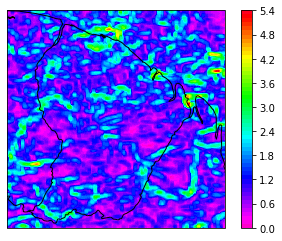

c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [45]:
agr_dir = main_dir + r"/agregation"
key = "IR_087" ; var = True
#key = "SSMIS" ; var = False
agregation(path_dates,agr_dir,key,compute_var=var)

## Classification

Segmentation des images en entrée à partir de la méthode des K-means

c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


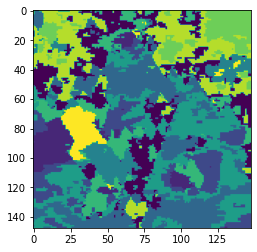

In [46]:
seg_dir = main_dir + r"/segmentation"
array_pred,centers = classification(agr_dir,seg_dir,projection,N=10,epsilon=0.001,T=100)

## no man's land

o

o

o

o

o

o

o


In [ ]:

"""
from osgeo import gdal
a = r"../../data/SSMI/download_dec_2021\238356902\NSIDC-0630-EASE2_N25km-F18_SSMIS-2021333-91V-E-GRD-CSU_ICDR-v1.5.nc"
ds = gdal.Open("NETCDF:{0}:{1}".format(a, "TB_time"))
print(ds.GetGeoTransform())
"""

# ex code
def selection_dir(dir,projection,attribute,zero_rate=0.1):
    paths = glob.glob(dir + "*/*.nc")
    out_dict = {}
    for path in paths:
        file = File(path)
        image = file.project("temporary.tiff",projection,attribute)
        arr = image.array
        try :
            unique, counts = np.unique(arr, return_counts=True)
            zero_rate = dict(zip(unique, counts))[0]/(arr.shape[0]*arr.shape[1])
        except KeyError:
            zero_rate = 0
        if zero_rate < 0.1:
            date = file.getTime(projection,f"{attribute}_time")
            date = date.strftime("%Y-%m-%d %H:%M:%S")
            out_dict[date] = path
    with open(dir+"dates.json", 'w', encoding='utf-8') as f:
        json.dump(out_dict, f, ensure_ascii=False, indent=4)
    return out_dict

def download_IR(filenames,projection,attribute):
    for fn in filenames:
        file = File(fn)
        date = fn.split("-")[-2]
        yyyy,mm,dd = date[:4],date[4:6],date[6:8]
        file.project(rf"../data/IR/agregation/{attribute}_{yyyy}-{mm}-{dd}.tiff",projection,attribute)
    """
    file = File(fn)
    download_all(file,r"../data/IR/results/IR{")
    """

def aggregation(projection,out_name,images=[],dir=False,mode="mean"):
    if dir:
        images = []
        filenames = glob.glob(rf"{dir}*.tiff")
        for fn in filenames:
            file = File(fn)
            images.append(file.getImage(1).array)
            lons,lats = file.getImage(1).lons, file.getImage(1).lats
    if mode == "mean":
        output = np.mean(np.array(images),axis=0)
    else:
        output = np.sum(np.array(images),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_name)
    
def search_near_SSMI(dir,projection,tg_date="*",freq="*",pola="*"):
    year = str(tg_date.year)
    days = (tg_date - datetime.strptime(year,"%Y")).days
    delta_min, fn_min = np.iinfo(np.int32).max, None
    for offset in [-1,0,1]:
        fns = glob.glob(dir+ rf"/*/*{year}{days+offset}-{freq}{pola}-*.nc")
        for fn in fns:
            file = File(fn)
            acq_date = file.getTime(projection,"TB_time").replace(tzinfo=None)
            img = file.project(r"../data/test.tiff",projection,"TB")
            delta = (tg_date-acq_date).total_seconds()
            try :
                unique, counts = np.unique(img.array, return_counts=True)
                zero_rate = dict(zip(unique, counts))[0]/(img.array.shape[0]*img.array.shape[1])
            except KeyError:
                zero_rate = 0
            if (zero_rate < 0.1) and (np.abs(delta) < delta_min):
                delta_min, fn_min = delta, fn
    file = File(fn_min)
    return file, file.getTime(projection,"TB_time")

def prepare_data_RACC(main_dir,dates,projection):
    """
    sélectionne parmis les données SSMIS et IR les fichiers d'intérêt 
    télécharge ces fichiers puis les géoréférence de la même manière
    aggrège les données et calcule la variance des images IR
    """
    SSMI_imgs = []
    for date in dates:
        dt = datetime.strptime(date, "%Y-%m-%d %H:%M:%S") ; freq = 91 ; pola = "*"
        file,acq = search_near_SSMI("../data/SSMI/download_dec_2021",projection,dt,freq,pola)
        date_str = acq.strftime("%Y-%m-%d")
        img = file.project(rf"../data/RACC/produced/SSMIS_{date_str}.tiff",projection,"TB")
        SSMI_imgs.append(img.array)
    aggregation(projection,rf"../data/RACC/produced/SSMIS_agrege.tiff",SSMI_imgs)



    prepare_data_RACC(dir,dates,projection)
    

    #download_IR(glob.glob(r"../data/IR/*.nat"),projection,"IR_087")

    #aggregation(r"../data/SSMI/agregation/",projection,"mean")
    #aggregation(r"../data/IR/agregation/",projection,"mean",True)

    """
    
    dates_dir = json.load(open(r"../data/SSMI/dates.json", "r", encoding="utf-8"))
    
    for d in dates:
        filename = dates_dir[d].split("-")
        filename[-5] = "19V"
        f = '-'.join(filename)
        print(f)
    #download_SSMI_from_json(f"{dir}dates.json",dates,projection)
    """

"""
    #attributes = ['HRV', 'IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073'] 
    attributes = ['IR_087']
    for att in attributes:
        out_path = rf"../data/test_seg/Meteosat_{att}.tiff"
        compute_var_path = rf"../data/test_seg/Meteosat_{att}_var.tiff"
        values = convert_nat(nat_path,out_path,proj_path,att,compute_var_path)

         for date in dates_dir.keys():
        dates_list.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
    dates = matplotlib.dates.date2num(dates_list)
    y = [1 for i in range(len(dates_list))]
    plt.plot_date(dates,y)
    plt.show()

    
    dates_list = list(dates_dir.keys())
    dates_list.sort()
    print(dates_list)
    """

